# Perform ETL and train a model using PySpark

To perform extract transform load (ETL) operations on multiple files, we recommend opening a Jupyter notebook within Amazon SageMaker Studio and using the `Glue PySpark and Ray` kernel. The kernel is connected to an AWS Glue Interactive Session. The session connects your notebook to a cluster that automatically scales up the storage and compute to meet your data processing needs. When you shut down the kernel, the session stops and you're no longer charged for the compute on the cluster.

Within the notebook you can use Spark commands to join and transform your data. Writing Spark commands is both faster and easier than writing SQL queries. For example, you can use the join command to join two tables. Instead of writing a query that can sometimes take minutes to complete, you can join a table within seconds.

To show the utility of using the PySpark kernel for your ETL and model training worklows, we're predicting the fare amount of the NYC taxi dataset. It imports data from 47 files across 2 different Amazon Simple Storage Service (Amazon S3) locations. Amazon S3 is an object storage service that you can use to save and access data and machine learning artifacts for your models. For more information about Amazon S3, see [What is Amazon S3?](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html).

The notebook is not meant to be a comprehensive analysis. Instead, it's meant to be a proof of concept to help you quickly get started.

__Prerequisites:__

This tutorial assumes that you've in the us-east-1 AWS Region. It also assumes that you've provided the IAM role you're using to run the notebook with permissions to use Glue. For more information, see [Providing AWS Glue permissions
](docs.aws.amazon.com/sagemaker/latest/dg/perform-etl-and-train-model-pyspark.html#providing-aws-glue-permissions).

## Solution overview 

To perform ETL on the NYC taxi data and train a model, we do the following

1. Start a Glue Session and load the SageMaker Python SDK
2. Set up the utilities needed to work with AWS Glue.
3. Load the data from the Amazon S3 into Spark dataframes.
4. Verify that we've loaded the data successfully.
5. Save a 20000 row sample of the Spark dataframe as a pandas dataframe.
6. Create a correlation matrix as an example of the types of analyses we can perform.
7. Split the Spark dataframe into training, validation, and test datasets.
8. Write the datasets to Amazon S3 locations that can be accessed by an Amazon SageMaker training job.
9. Use the training and validation datasets to train a model.

### Start a Glue Session and load the SageMaker Python SDK

In [2]:
%additional_python_modules sagemaker

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.5 
Additional python modules to be included:
sagemaker


### Set up the utilities needed to work with AWS Glue

We're importing `Join` to join our Spark dataframes.  `GlueContext` provides methods for transforming our dataframes. In the context of the notebook, it reads the data from the Amazon S3 locations and uses the Spark cluster to transform the data. `SparkContext` represents the connection to the Spark cluster. `GlueContext` uses `SparkContext` to transform the data. `getResolvedOptions` lets you resolve configuration options within the Glue interactive session.

In [1]:
import sys
from awsglue.transforms import Join
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

glueContext = GlueContext(SparkContext.getOrCreate())

Trying to create a Glue session for the kernel.
Session Type: etl
Session ID: 11fe1ff7-3608-485f-a4a3-65392596dba0
Applying the following default arguments:
--glue_kernel_version 1.0.5
--enable-glue-datacatalog true
--additional-python-modules sagemaker
Waiting for session 11fe1ff7-3608-485f-a4a3-65392596dba0 to get into ready status...
Session 11fe1ff7-3608-485f-a4a3-65392596dba0 has been created.



### Create the `df_ride_info` dataframe

Create a single dataframe from all the ride_info Parquet files for 2019.

In [2]:
df_ride_info = glueContext.create_dynamic_frame_from_options(
    connection_type="s3", format="parquet",
    connection_options={"paths": ["s3://dsoaws/nyc-taxi-orig-cleaned-split-parquet-per-year-multiple-files/ride-info/year=2019/"], "recurse": True}).toDF()

### Create the `df_ride_info` dataframe

Create a single dataframe from all the ride_fare Parquet files for 2019.

In [3]:
df_ride_fare = glueContext.create_dynamic_frame_from_options(
    connection_type="s3", format="parquet",
    connection_options={"paths": ["s3://dsoaws/nyc-taxi-orig-cleaned-split-parquet-per-year-multiple-files/ride-fare/year=2019/"], "recurse": True}).toDF()

### Show the first five rows of `dr_ride_fare`

In [4]:
df_ride_fare.show(5)

+-------------+------------+-----------+-----+-------+----------+------------+------------+
|      ride_id|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|total_amount|
+-------------+------------+-----------+-----+-------+----------+------------+------------+
|1400160115693|           2|       31.0|  0.0|    0.5|       0.0|        6.12|       40.42|
|3770982177323|           1|        4.5|  0.0|    0.5|       1.2|         0.0|         9.0|
|1400160115694|           1|       16.5|  1.0|    0.5|      4.16|         0.0|       24.96|
|3770982177324|           1|       18.0|  2.5|    0.5|       5.3|         0.0|        26.6|
|1400160115695|           1|        8.0|  2.5|    0.5|      1.13|         0.0|       12.43|
+-------------+------------+-----------+-----+-------+----------+------------+------------+
only showing top 5 rows


### Join df_ride_fare and df_ride_info on the `ride_id` column

In [5]:
df_joined = df_ride_info.join(df_ride_fare, ["ride_id"])

### Show the first five rows of the joined dataframe

In [6]:
df_joined.show(5)

+-----------+---------+---------------+-------------------+-------------------+-------------+------------+------------------+------------+-----------+-----+-------+----------+------------+------------+
|    ride_id|vendor_id|passenger_count|          pickup_at|         dropoff_at|trip_distance|rate_code_id|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|total_amount|
+-----------+---------+---------------+-------------------+-------------------+-------------+------------+------------------+------------+-----------+-----+-------+----------+------------+------------+
|51539607553|        1|              1|2019-04-21 17:20:19|2019-04-21 17:31:28|          2.7|           1|                 N|           1|       10.5|  2.5|    0.5|      3.45|         0.0|       17.25|
|51539607560|        2|              1|2019-02-21 22:49:59|2019-02-21 22:53:45|         0.62|           1|                 N|           2|        4.5|  0.5|    0.5|       0.0|         0.0|    

### Show the data types of the dataframe

In [7]:
df_joined.printSchema()

root
 |-- ride_id: long (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: byte (nullable = true)
 |-- pickup_at: timestamp (nullable = true)
 |-- dropoff_at: timestamp (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- rate_code_id: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- total_amount: float (nullable = true)


### Count the number of rows

In [8]:
df_joined.count()

44200708


### Drop duplicates if there are any

In [9]:
df_no_dups = df_joined.dropDuplicates(["ride_id"])

### Count the number of rows after dropping the duplicates

In this case, there were no duplicates in the original dataframe.

In [10]:
df_no_dups.count()

44200708


### Drop columns
Time series data and categorical data is outside of the scope of the notebook.

In [11]:
df_cleaned = df_joined.drop("pickup_at", "dropoff_at", "store_and_fwd_flag", "vendor_id", "payment_type")

### Take a sample from the notebook and convert it to a pandas dataframe

In [12]:
df_sample = df_cleaned.sample(False, 0.1, seed=0).limit(20000)

In [13]:
df_sample.count()

20000


In [14]:
df_pandas = df_sample.toPandas()
df_pandas.describe()

            ride_id  passenger_count  ...  tolls_amount  total_amount
count  2.000000e+04     20000.000000  ...  20000.000000  20000.000000
mean   5.327415e+10         1.580700  ...      0.354632     18.917547
std    3.447216e+09         1.218221  ...      1.540669     14.226608
min    5.153961e+10         0.000000  ...      0.000000    -59.799999
25%    5.154042e+10         1.000000  ...      0.000000     11.300000
50%    5.154121e+10         1.000000  ...      0.000000     14.750000
75%    5.154202e+10         2.000000  ...      0.000000     20.299999
max    6.013019e+10         6.000000  ...     21.500000    242.300003

[8 rows x 10 columns]


In [15]:
print("Dataset shape: ", df_pandas.shape)

Dataset shape:  (20000, 10)


In [16]:
df_pandas.head()

       ride_id  passenger_count  ...  tolls_amount  total_amount
0  51539607572                1  ...           0.0     10.550000
1  51539607730                5  ...           0.0     17.299999
2  51539607857                2  ...           0.0      6.800000
3  51539607985                1  ...           0.0      7.300000
4  51539608203                1  ...           0.0     16.559999

[5 rows x 10 columns]


In [17]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ride_id          20000 non-null  int64  
 1   passenger_count  20000 non-null  int8   
 2   trip_distance    20000 non-null  float32
 3   rate_code_id     20000 non-null  int32  
 4   fare_amount      20000 non-null  float32
 5   extra            20000 non-null  float32
 6   mta_tax          20000 non-null  float32
 7   tip_amount       20000 non-null  float32
 8   tolls_amount     20000 non-null  float32
 9   total_amount     20000 non-null  float32
dtypes: float32(7), int32(1), int64(1), int8(1)
memory usage: 800.9 KB


### Create a correlation matrix of the features

We're creating a correlation matrix to see which features are the most predictive. This is an example of an analysis that you can use for your own use case.

<AxesSubplot:>



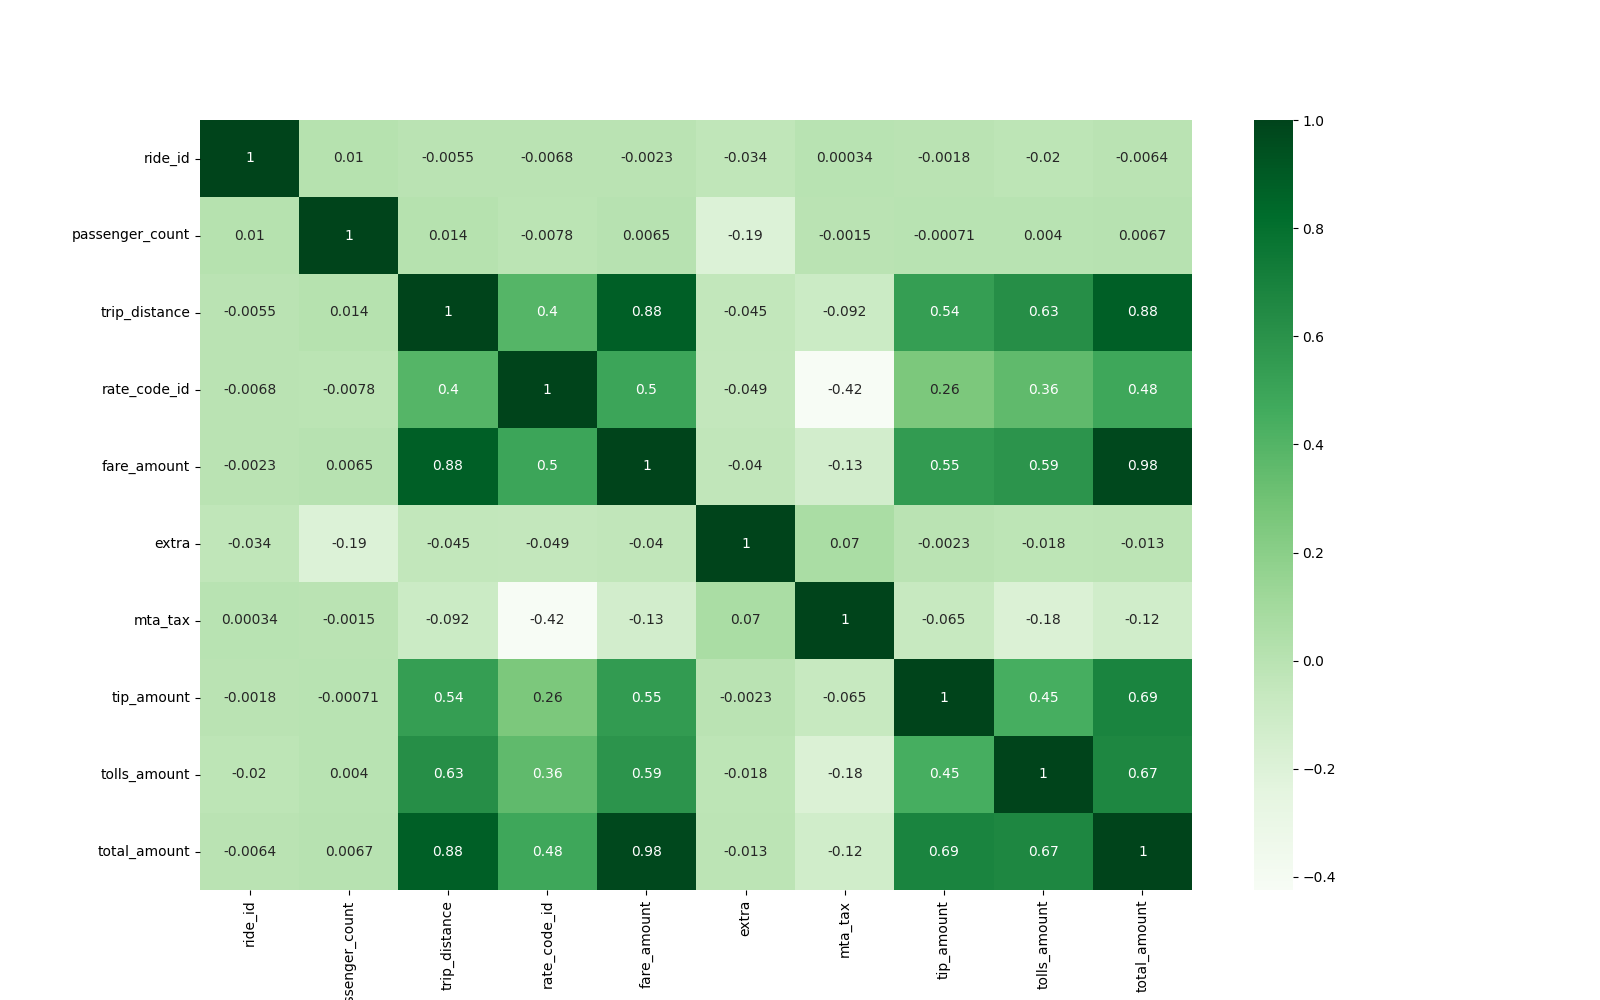

In [18]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd # not sure how the kernel runs, but it looks like I have import pandas again after going back to the notebook after a while

vector_col = 'corr_features'
assembler = VectorAssembler(inputCols=df_sample.columns, outputCol=vector_col)
df_vector = assembler.transform(df_sample).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=df_sample.columns, index=df_sample.columns) 

plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

%matplot plt

### Split the dataset into train, validation, and test sets

In [19]:
df_train, df_val, df_test = df_cleaned.randomSplit([0.7, 0.15, 0.15])

### Define the Amazon S3 locations that store the datasets

If you're getting a module not found error, restart the kernel and run all the cells again.

In [20]:
# Define the S3 locations to store the datasets
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker_session.default_bucket()
train_data_prefix = "sandbox/glue-demo/train"
validation_data_prefix = "sandbox/glue-demo/validation"
test_data_prefix = "sandbox/glue-demo/test"
region = boto3.Session().region_name

### Write the files to the locations

In [22]:
df_train.write.parquet(f"s3://{s3_bucket}/{train_data_prefix}", mode="overwrite")

In [23]:
df_val.write.parquet(f"s3://{s3_bucket}/{validation_data_prefix}", mode="overwrite")

In [24]:
df_test.write.parquet(f"s3://{s3_bucket}/{test_data_prefix}", mode="overwrite")

### Train a model

The following code uses the `df_train` and `df_val` datasets to train an XGBoost model. 

In [ ]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"reg:squarederror",
        "num_round":"50"}

# Set an output path to save the trained model.
prefix = 'sandbox/glue-demo'
output_path = f's3://{s3_bucket}/{prefix}/xgb-built-in-algo/output'

# The following line looks for the XGBoost image URI and builds an XGBoost container.
# We use version 1.7-1 of the image URI, you can specify a version that you prefer.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

# Construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1,
                                          instance_type='ml.m5.4xlarge',
                                          output_path=output_path)

content_type = "application/x-parquet"
train_input = TrainingInput(f"s3://{s3_bucket}/{prefix}/train/", content_type=content_type)
validation_input = TrainingInput(f"s3://{s3_bucket}/{prefix}/validation/", content_type=content_type)

# Run the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input})

### Clean up

To clean up, shut down the kernel. Shutting down the kernel, stops the Glue cluster. You won't be charged for any more compute other than what you used to run the tutorial.